In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# Import data frame from Github

df = pd.read_csv("https://raw.githubusercontent.com/NevenaKlo/Plane-crashes-analysis/refs/heads/main/aviation-accidents.csv")
df.head()

,date,type,registration,operator,fatalities,location,country,cat,year
0,date unk.,Antonov An-12B,T-1206,Indonesian AF,NaN,NaN,Unknown country,U1,unknown
1,date unk.,Antonov An-12B,T-1204,Indonesian AF,NaN,NaN,Unknown country,U1,unknown
2,date unk.,Antonov An-12B,T-1201,Indonesian AF,NaN,NaN,Unknown country,U1,unknown
3,date unk.,Antonov An-12BK,NaN,Soviet AF,NaN,Tiksi Airport (IKS),Russia,A1,unknown
4,date unk.,Antonov An-12BP,CCCP-11815,Soviet AF,0,Massawa Airport ...,Eritrea,A1,unknown


In [4]:
# Get the most frequently occurring country (mode) in the dataset's 'country' column
# This identifies which country has the highest recorded crash count

most_common_country = df["country"].mode()
print(most_common_country)

# Output:
# 0    USA
# dtype: object
# Interpretation: USA is the most frequent value in 'country', meaning it has the highest crash count.

0    USA
Name: country, dtype: object


In [5]:
# Is there a day of the week in which crashes occur more often?
# First, inspect column "date"

df["date"].unique()

array(['date unk.', '02-AUG-1919', '11-AUG-1919', ..., '12-MAY-2023',
       '14-MAY-2023', '15-MAY-2023'], dtype=object)

In [6]:
# Because "dates" contains strings, we cannot apply functions such as dt.day_name() to extract info about days of the week
# Convert date values to datetime so that we can apply dt.day_name()

df["date"] = pd.to_datetime(df['date'], format='%d-%b-%Y', errors='coerce')

df["date"].dtype

dtype('<M8[ns]')

In [7]:
# Inspect the dataframe to check whether there are any unusual data

df["date"].value_counts()

,count
date,
1940-05-10,171
1945-03-24,50
1944-06-06,41
1944-09-17,35
1944-09-18,29
...,...
1921-08-26,1
1921-03-04,1
1921-03-02,1


In [8]:
# one date has an unusually high number of crushes
# check if it is a genuine number or not: select dates which record more than 20 crashes, and group information about operators and locations

count_suspect_dates = df["date"].value_counts()
suspect_dates = count_suspect_dates[count_suspect_dates > 20].index

suspects = df[df["date"].isin(suspect_dates)].sort_values(["date", "operator", "location"])

summary = (
    suspects
    .groupby("date")
    .agg(
        n_rows=("type", "size"),
        operators=("operator", lambda s: sorted(s.dropna().unique().tolist())),
        locations=("location", lambda s: sorted(s.dropna().unique().tolist())),
    )
    .sort_values("n_rows", ascending=False)
)
summary

,n_rows,operators,locations
date,,,
1940-05-10,171,"[German AF, KLM, Netherlands AF]","['s Gravenzande, 't Woudt, Amsterdam-Schiph......"
1945-03-24,50,"[RAF, USAAF]","[Henderson Field ..., Riswickhof, Weeze, near ..."
1944-06-06,41,"[German AF, RAF, USAAF]","[Bassenville, Beuzeville-au-Plain, Broadwell R..."
1944-09-17,35,[USAAF],"[Bladel, Boxtel, Casteren, Erp, Groesbeek, Gro..."
1944-09-18,29,"[German AF, RAF, USAAF, USAAF, op.for Northwes...","[Afferden, Agartala Airport..., Dodewaard, Ein..."
1944-09-19,28,"[RAF, South African AF, USAAF]","[Algiers-Maison B..., Arnhem, Best, Bordj Mena..."
1944-09-21,26,"[Panair do Brasil, RAF, RCAF, USAAF]","[Arendonk, Arnhem, Bemmel, Doorwerth, Driel, E..."
1941-12-07,23,[US Navy],"[Ford Island NAS,...]"
1944-06-07,22,"[German AF, RAAF, RAF, USAAF]","[Cazaux, Cottesmore RAF S..., English Channel,..."


In [9]:
# for each date, many locations are recorded, so the dates might be genuine
# count number of locations: if they are significantly differ from the number of crashes,
# it likely means that crashes occured at different times have been recorded under the same date

num_locations = (
    df.groupby("date")
      .filter(lambda x: len(x) > 20)
      .groupby("date")
      .agg(
          n_crashes=("type", "size"),
          n_locations=("location", pd.Series.nunique)
      )
      .sort_values("n_crashes", ascending=False)
)

num_locations.head()

,n_crashes,n_locations
date,,
1940-05-10,171,63
1945-03-24,50,14
1944-06-06,41,29
1944-09-17,35,24
1944-09-18,29,25


In [10]:
# For some of the dates, a series of crushes which have occured at different times have likely been recorded under the same day
# in order to determine the day of the week in which more crushes occur, I exclude these suspicious dates
# Make a copy of the df filtering out these dates

bad_dates = [
    "1940-05-10",
    "1945-03-24",
    "1944-06-06",
    "1944-09-17",
    "1944-09-18",
]

df_filtered = df[~df["date"].isin(bad_dates)].copy()

/tmp/ipython-input-1246318294.py:13: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  df_filtered = df[~df["date"].isin(bad_dates)].copy()


In [11]:
# Extract day of week
df_filtered["day_of_week"] = df_filtered["date"].dt.day_name()

In [12]:
# Count occurrences of each week day (most frequent = Friday, closely followed by Thursday)
most_frequent_days = df_filtered["day_of_week"].value_counts()
print(most_frequent_days)

day_of_week
Friday       3530
Thursday     3516
Wednesday    3491
Tuesday      3403
Monday       3288
Saturday     3136
Sunday       2718
Name: count, dtype: int64


In [13]:
# Safest operators to fly with, calculated as operator with the least amount of fatalities given the amount of crashes with n_crushes > 10
# inspect the column operator

df["operator"].info()

<class 'pandas.core.series.Series'>
RangeIndex: 23967 entries, 0 to 23966
Series name: operator
Non-Null Count  Dtype 
--------------  ----- 
23963 non-null  object
dtypes: object(1)
memory usage: 187.4+ KB


In [16]:
#inspect fatalities column

fatalities = df['fatalities'].unique()
print(fatalities)

# Output: fatalities include unknown values and n+n values

[nan '0' '14' '1' '4' '2' '5' '6' '3' '7' '5+ 1' '8' '16' '12' '9' '15'
 '14+ 1' '10' '11' '35+ 9' '13' '2+ 2' '17' '19' '20' '0+ 1' '18' '13+ 1'
 '25' '29' '23' '5+ 7' '24' '36' '26' '22' '27' '12+ 1' '21' '7+ 6' '35'
 '32' '31' '2+ 1' '34' '28' '20+ 5' '0+ 2' '30' '41' '59' '13+ 7' '45'
 '44' '37' '3+ 5' '4+ 6' '30+ 1' '19+ 1' '39' '11+ 1' '43' '53' '0+ 3'
 '50' '14+ 3' '3+ 1' '52' '8+ 1' '5+ 3' '40' '0+ 6' '8+ 2' '33' '48' '55'
 '1+ 1' '38' '0+ 7' '32+ 1' '13+ 2' '80' '1+ 2' '46' '58' '51' '10+ 3'
 '56' '23+ 7' '29+ 4' '2+ 3' '5+ 2' '87' '129' '42' '5+ 10' '35+ 1' '47'
 '66' '1+ 4' '5+ 4' '74' '70' '62' '17+ 1' '4+ 3' '18+ 2' '20+ 2' '67'
 '79' '5+ 6' '6+ 1' '61' '41+ 1' '21+ 2' '99' '64' '3+ 4' '65' '1+ 9' '68'
 '54' '3+ 8' '32+ 10' '6+ 2' '63' '7+ 1' '84+ 6' '20+ 32' '6+ 3' '72+ 1'
 '78' '72' '27+ 3' '83' '77' '3+ 2' '95' '111' '107' '130' '113' '84' '94'
 '81' '86' '97' '6+ 7' '14+ 87' '7+ 2' '101' '15+ 1' '118' '85' '49'
 '79+ 1' '57' '7+ 22' '121' '3+ 11' '11+ 3' '117' '133' '1

In [17]:
# Use a function that splits the values at the two ends of "+" (when this is present), transforms the values in integers and sums them
# otherwise just transforms the value to an integer
# apply to column "fatalities" of df

def num_fatalities(fatalities):
  if pd.isna(fatalities):
    return None
  if "+" in fatalities:
    parts = fatalities.split("+")
    return int(parts[0]) + int(parts[1])
  else:
    return int(fatalities)

df["fatalities"].apply(num_fatalities)

,fatalities
0,NaN
1,NaN
2,NaN
3,NaN
4,0.0
...,...
23962,0.0
23963,0.0
23964,0.0
23965,0.0


In [18]:
# Create a numeric column so that we can run calculations
df["fatalities_num"] = df["fatalities"].apply(num_fatalities).astype('Int64')

In [19]:
# count crushes per operator and exclude those with less than 10

operator_counts = df["operator"].value_counts()

op_more_10 = operator_counts[operator_counts >=10]

op_more_10


df_operators_filtered = df[df["operator"].isin(op_more_10.index)]
print(df_operators_filtered)

            date              type registration       operator fatalities  \
0            NaT    Antonov An-12B       T-1206  Indonesian AF        NaN   
1            NaT    Antonov An-12B       T-1204  Indonesian AF        NaN   
2            NaT    Antonov An-12B       T-1201  Indonesian AF        NaN   
3            NaT   Antonov An-12BK          NaN      Soviet AF        NaN   
4            NaT   Antonov An-12BP   CCCP-11815      Soviet AF          0   
...          ...               ...          ...            ...        ...   
23953 2023-04-21     Antonov An-26         7705       Sudan AF          0   
23954 2023-04-21     Antonov An-26         7777       Sudan AF          0   
23955 2023-04-21     Antonov An-30         7708       Sudan AF          0   
23956 2023-04-21    Antonov An-32B         7709       Sudan AF          0   
23959 2023-04-26  Boeing 777-233LR       C-FIUF     Air Canada          0   

                  location          country cat     year  fatalities_num  


In [21]:
operator_stats = (
    df_operators_filtered.groupby("operator", as_index=False)
      .agg(
          n_crashes=("operator", "size"),
          total_fatalities=("fatalities_num", "sum")
      )
)

# Calculate ratio (fatality per crashes)
operator_stats["fatality_per_crashes"] = (
    operator_stats["total_fatalities"] / operator_stats["n_crashes"]
)

operator_stats = operator_stats.sort_values(
    by="fatality_per_crashes"
)

print(operator_stats.head(10))

                    operator  n_crashes  total_fatalities  \
249  Trans Maldivian Airways         12                 0   
216                  Ryanair         13                 0   
130                    HISMA         10                 0   
86           Buffalo Airways         11                 0   
227       Southwest Airlines         26                 2   
120                    FedEx         19                 2   
271                      ZUA         36                 4   
95           Cessna Aircraft         16                 2   
128           Grant Aviation         10                 2   
174               Martinaire         13                 3   

     fatality_per_crashes  
249                   0.0  
216                   0.0  
130                   0.0  
86                    0.0  
227              0.076923  
120              0.105263  
271              0.111111  
95                  0.125  
128                   0.2  
174              0.230769  


In [22]:
# Which type (model) of airplanes caused the highest number of fatalities?

# Sum fatalities by airplane type and sort descending

totals_by_type = (
    df.groupby("type", as_index=False)["fatalities_num"]
      .sum()
      .sort_values(by="fatalities_num", ascending=False)
)

print(totals_by_type.head())

                      type  fatalities_num
1710  Douglas C-47A (DC-3)            5780
1706   Douglas C-47 (DC-3)            2676
1711  Douglas C-47B (DC-3)            2017
1025      Boeing 767-223ER            1692
3057       Tupolev Tu-154M            1600


In [23]:
# Evolution of crashes after the 11th of September 2011

# Did the overall number of crashes change in the USA?
# did the ratio fatalities per crash change?

# Some things to consider are: there are more records before 9/11 (the dataset starts from 1919), so it would not be fair to compare all crashes before and after
# There also used to be more crashes in the past because of less reliable airplanes. WW2 further inflates the numbers.
# I here only consider the years 2000 to 2011, and 2011 to 2023


df["date"] = pd.to_datetime(df["date"], errors="coerce")

cutoff_start = pd.Timestamp("2000-01-01")

df_usa = df.loc[
    (df["country"].str.contains("USA", na=False))
    & (df["date"] >= cutoff_start)
    ].copy()

df_usa["fatalities_num"] = df_usa["fatalities"].apply(num_fatalities).astype("Int64")

cutoff_date = pd.Timestamp("2001-09-11")
df_usa["period"] = np.where(df_usa["date"] < cutoff_date, "Before 9/11", "After 9/11")

usa_stats = (
    df_usa.groupby("period", as_index=False)
          .agg(
              total_crashes=("type", "size"),
              total_fatalities=("fatalities_num", "sum")
          )
)

usa_stats["fatalities_per_crash"] = (
    usa_stats["total_fatalities"] / usa_stats["total_crashes"]
)

print(usa_stats)


        period  total_crashes  total_fatalities  fatalities_per_crash
0   After 9/11           1048              3877              3.699427
1  Before 9/11             77               195              2.532468


In [25]:
# Crashes per country

crahses_per_country = df["country"].value_counts()
print(crahses_per_country)

# Output: the USA has the highest number of recorded crashes

country
USA                4377
Russia             1422
Unknown country     838
U.K.                837
Canada              826
                   ... 
Cook Isl.             1
Kosovo                1
Burundi               1
Eswatini              1
Macau                 1
Name: count, Length: 232, dtype: int64


In [26]:
# Create a df with name of Countries and number of crashes

country_counts = df["country"].value_counts().reset_index()
country_counts.columns = ["country", "n_crashes"]
print(country_counts)

             country  n_crashes
0                USA       4377
1             Russia       1422
2    Unknown country        838
3               U.K.        837
4             Canada        826
..               ...        ...
227        Cook Isl.          1
228           Kosovo          1
229          Burundi          1
230         Eswatini          1
231            Macau          1

[232 rows x 2 columns]


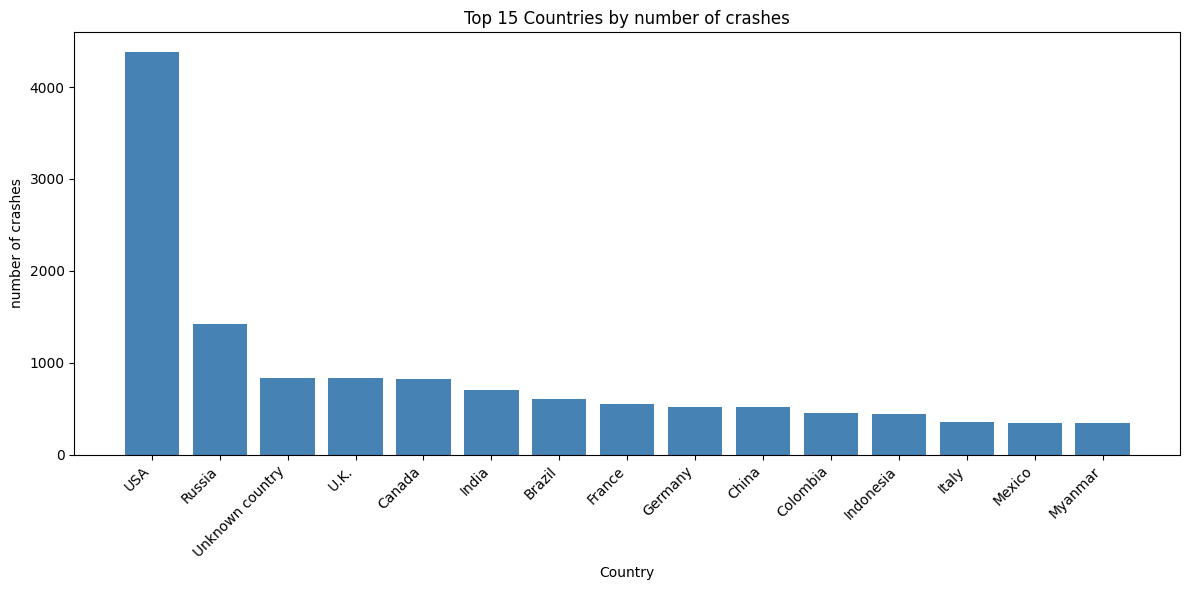

In [27]:
# bar chart using the previous df

top_n = 15
top_countries = country_counts.head(top_n)

plt.figure(figsize=(12, 6))
plt.bar(top_countries["country"], top_countries["n_crashes"], color="steelblue")

plt.xticks(rotation=45, ha="right")
plt.xlabel("Country")
plt.ylabel("number of crashes")
plt.title(f"Top {top_n} Countries by number of crashes")
plt.tight_layout()
plt.show()

/tmp/ipython-input-2753244478.py:10: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  .resample('Y')['n'].sum()


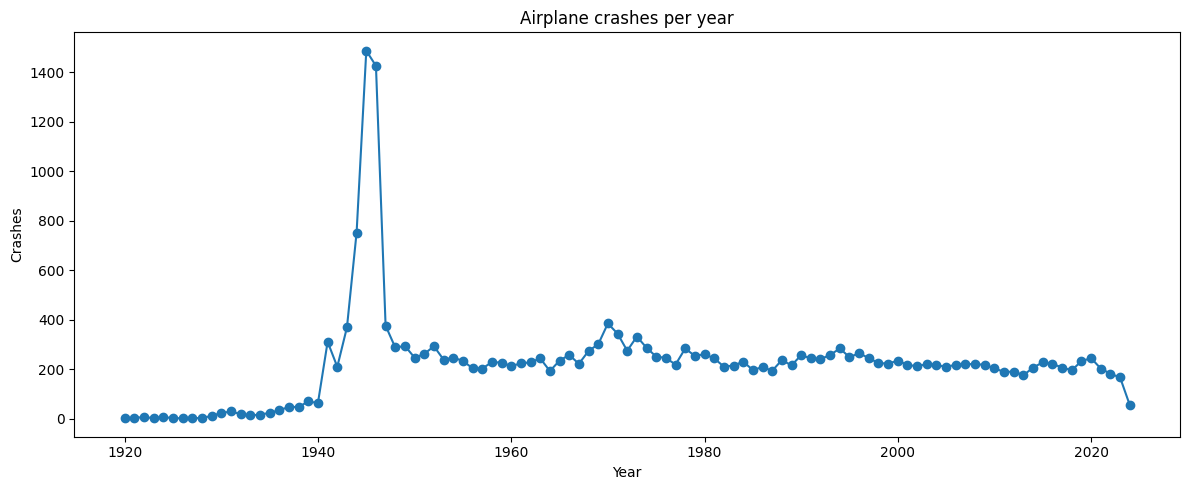

In [28]:
# How is the number of crasehs changing throughout this window of time?

df["date"] = pd.to_datetime(df["date"], errors="coerce")
df = df.dropna(subset=["date"])


yearly = (
    df.set_index("date")
      .assign(n=1)
      .resample('Y')['n'].sum()
)

plt.figure(figsize=(12,5))
plt.plot(yearly.index, yearly.values, marker='o')
plt.title('Airplane crashes per year')
plt.xlabel('Year'); plt.ylabel('Crashes'); plt.tight_layout()
plt.show()